satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64


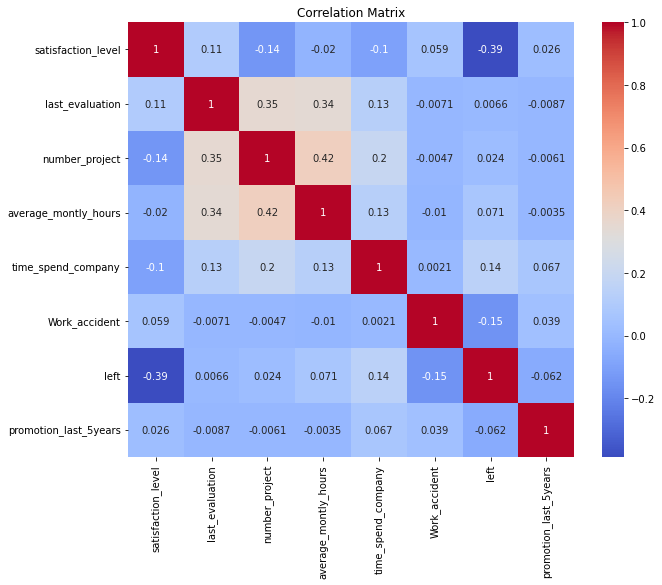

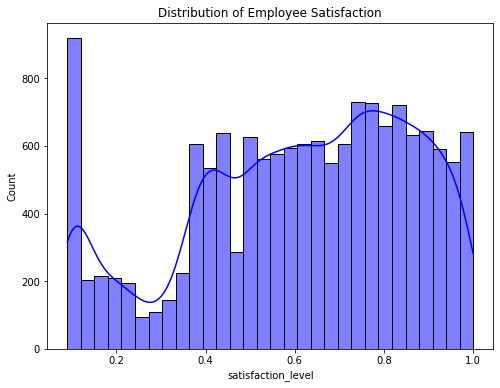

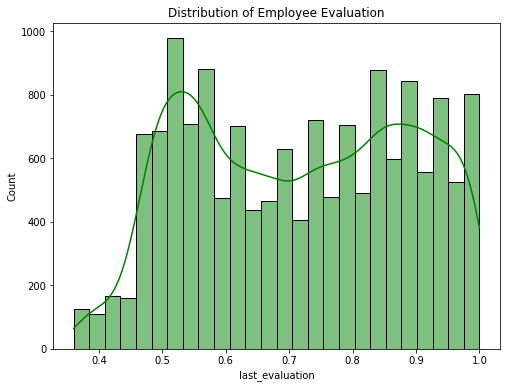

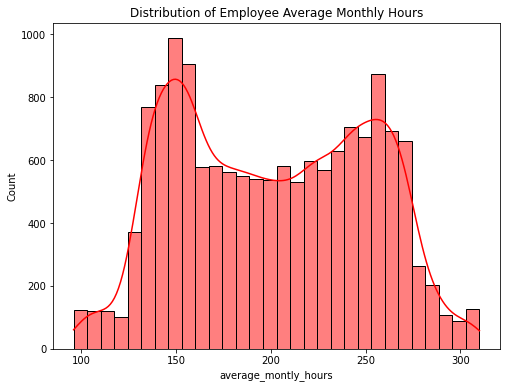

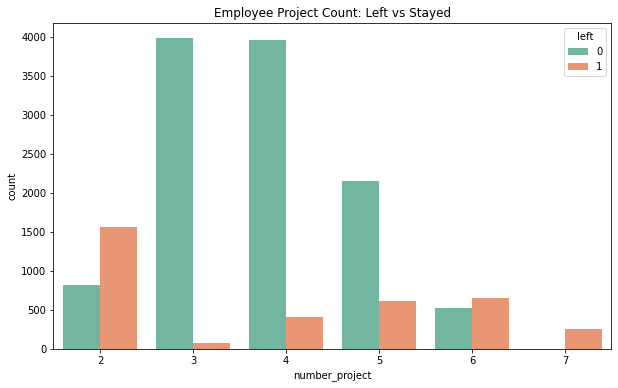

/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


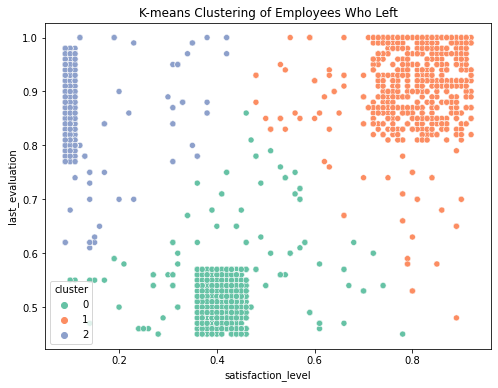

              precision    recall  f1-score   support

           0       0.90      0.80      0.85      2286
           1       0.53      0.71      0.61       714

    accuracy                           0.78      3000
   macro avg       0.71      0.76      0.73      3000
weighted avg       0.81      0.78      0.79      3000



In [ ]:
# 1. Perform Data Quality Checks
import pandas as pd
# Load the dataset
df = pd.read_csv('HR_comma_sep.csv')
# Check for missing values
print(df.isnull().sum())

# 2. Understand What Factors Contributed Most to Employee Turnover at EDA

# 2.1. Draw a Heatmap of the Correlation Matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Compute the correlation matrix
corr = df.corr(numeric_only=True)
# Draw the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# 2.2. Draw the Distribution Plot
# Distribution plot for satisfaction_level
plt.figure(figsize=(8, 6))
sns.histplot(df['satisfaction_level'], kde=True, color='blue')
plt.title('Distribution of Employee Satisfaction')
plt.show()
# Distribution plot for last_evaluation
plt.figure(figsize=(8, 6))
sns.histplot(df['last_evaluation'], kde=True, color='green')
plt.title('Distribution of Employee Evaluation')
plt.show()
# Distribution plot for average_montly_hours
plt.figure(figsize=(8, 6))
sns.histplot(df['average_montly_hours'], kde=True, color='red')
plt.title('Distribution of Employee Average Monthly Hours')
plt.show()

# 2.3. Draw the Bar Plot of Employee Project Count
# Bar plot of employee project count
plt.figure(figsize=(10, 6))
sns.countplot(x='number_project', hue='left', data=df, palette='Set2')
plt.title('Employee Project Count: Left vs Stayed')
plt.show()

# 3. Perform Clustering of Employees Who Left Based on Their Satisfaction and Evaluation

# 3.1. Choose Columns
# Select relevant columns
df_left = df[df['left'] == 1][['satisfaction_level', 'last_evaluation']]

# 3.2. Perform K-means Clustering
from sklearn.cluster import KMeans
# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_left['cluster'] = kmeans.fit_predict(df_left)
# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='satisfaction_level', y='last_evaluation', hue='cluster', data=df_left, palette='Set2')
plt.title('K-means Clustering of Employees Who Left')
plt.show()

# 3.3. Thoughts on Employee Clusters
# Based on the clustering, we can identify groups of employees who left due to low satisfaction, high evaluation but low satisfaction, and other patterns.


# 4. Handle the Left Class Imbalance Using the SMOTE Technique

# 4.1. Pre-process the Data
# Separate categorical and numeric variables
categorical_cols = ['sales', 'salary']
numeric_cols = df.columns.difference(categorical_cols + ['left'])
# Apply get_dummies to categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_cols)
# Combine categorical and numeric variables
df_final = df_encoded[numeric_cols.tolist() + df_encoded.columns.difference(numeric_cols).tolist()]

# 4.2. Stratified Split of the Dataset
from sklearn.model_selection import train_test_split
# Stratified split
X = df_final.drop('left', axis=1)
y = df_final['left']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

# 4.3. Upsample the Train Dataset Using SMOTE
from imblearn.over_sampling import SMOTE
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 5. Perform 5-fold Cross-Validation Model Training and Evaluate Performance

# 5.1. Train a Logistic Regression Model
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
# Train Logistic Regression
log_reg = LogisticRegression(max_iter=500, solver='lbfgs', random_state=42)
log_reg_scores = cross_val_score(log_reg, X_train_smote_scaled, y_train_smote, cv=5, scoring='f1')

log_reg.fit(X_train_smote_scaled, y_train_smote)
y_pred_log_reg = log_reg.predict(X_test_scaled)
print(classification_report(y_test, y_pred_log_reg))

# 5.2. Train a Random Forest Classifier Model
from sklearn.ensemble import RandomForestClassifier
# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf_scores = cross_val_score(rf, X_train_smote, y_train_smote, cv=5, scoring='f1')
# Classification report
rf.fit(X_train_smote, y_train_smote)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

# 5.3. Train a Gradient Boosting Classifier Model
from sklearn.ensemble import GradientBoostingClassifier
# Train Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb_scores = cross_val_score(gb, X_train_smote, y_train_smote, cv=5, scoring='f1')
# Classification report
gb.fit(X_train_smote, y_train_smote)
y_pred_gb = gb.predict(X_test)
print(classification_report(y_test, y_pred_gb))

# 6. Identify the Best Model and Justify the Evaluation Metrics Used

# 6.1. Find the ROC/AUC for Each Model
from sklearn.metrics import roc_curve, auc
# ROC/AUC for Logistic Regression
fpr, tpr, _ = roc_curve(y_test, log_reg.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % roc_auc)
# ROC/AUC for Random Forest
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='Random Forest (AUC = %0.2f)' % roc_auc)
# ROC/AUC for Gradient Boosting
fpr, tpr, _ = roc_curve(y_test, gb.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='Gradient Boosting (AUC = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 6.2. Find the Confusion Matrix for Each Model
from sklearn.metrics import confusion_matrix
# Confusion Matrix for Logistic Regression
print(confusion_matrix(y_test, y_pred_log_reg))
# Confusion Matrix for Random Forest
print(confusion_matrix(y_test, y_pred_rf))
# Confusion Matrix for Gradient Boosting
print(confusion_matrix(y_test, y_pred_gb))

# 6.3. Explain Which Metric to Use: Recall or Precision?
# In the context of employee turnover, recall is more important because we want to identify as many employees who are likely to leave as possible, even if it means some false positives.

# 7. Suggest Various Retention Strategies for Targeted Employees

# 7.1. Predict the Probability of Employee Turnover
# Predict probabilities using the best model (e.g., Gradient Boosting)
y_pred_proba = gb.predict_proba(X_test)[:, 1]

# 7.2. Categorize Employees into Four Zones
# Categorize employees based on probability score
def categorize_employee(score):
    if score < 0.2:
        return 'Safe Zone (Green)'
    elif 0.2 <= score < 0.6:
        return 'Low-Risk Zone (Yellow)'
    elif 0.6 <= score < 0.9:
        return 'Medium-Risk Zone (Orange)'
    else:
        return 'High-Risk Zone (Red)'
df_test = X_test.copy()
df_test['probability'] = y_pred_proba
df_test['zone'] = df_test['probability'].apply(categorize_employee)
# Retention strategies for each zone
safe_zone = df_test[df_test['zone'] == 'Safe Zone (Green)']
low_risk_zone = df_test[df_test['zone'] == 'Low-Risk Zone (Yellow)']
medium_risk_zone = df_test[df_test['zone'] == 'Medium-Risk Zone (Orange)']
high_risk_zone = df_test[df_test['zone'] == 'High-Risk Zone (Red)']
# Suggest retention strategies
print("Safe Zone: Maintain current engagement levels.")
print("Low-Risk Zone: Provide additional training and career development opportunities.")
print("Medium-Risk Zone: Conduct one-on-one meetings to address concerns and offer support.")
print("High-Risk Zone: Immediate intervention with personalized retention plans and incentives.")

